In [91]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
import random
%matplotlib inline
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

First lets load al the paths of the images

In [3]:
path = "D:\\ML_SEM2\\train"
train_path = []
for file in os.listdir(path):
    train_path.append(path + "\\"+file)

Now that we have all of our paths to the picturs, lets get the arrays of theirs picturs and resize them, and categorize tham as well

In [95]:
pixels = np.ndarray((len(train_path),10000)) #10000 = 100*100
categories = np.zeros(len(train_path))
i =0
for path in train_path:
    image = cv2.imread(path,0)#0 means we read the images as gray scale (like Fashion-Mnist)
    image = cv2.resize(image,(100,100))# to fit to size 10000
    data = image.flatten()
    pixels[i] = data 
    if "cat" in path:
        categories[i] = 0 #cats will be classified as 0
        i = i +1
    else:
        categories[i] = 1 #dogs will be classified as 1
        i = i +1


lets see that we have a balanced amount of cats and dogs

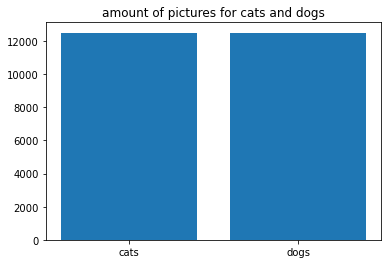

In [96]:
count = 0
for kind in categories:
    if kind ==1:
        count = count+1
amount = [count, len(categories)-count]        
xlabels = ["cats","dogs"]
plt.bar(x=xlabels, height =  amount)
plt.title("amount of pictures for cats and dogs");


as we can see we have the same amount of dog picutres and cat pictures

now lets see how an image looks from the path and how we loaded it up

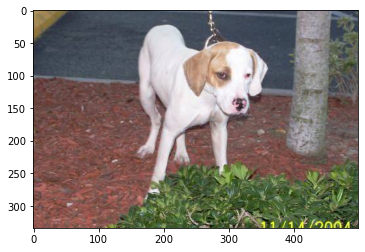

In [113]:
index = random.randint(0,24999)
image = cv2.imread(train_path[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

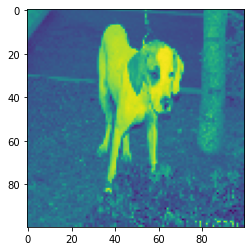

In [114]:
plt.figure()
plt.imshow(pixels[index].reshape(100,100))
plt.show()

now we can create dataframes of our data, and move on to spliting pur data and using it to train our models

In [121]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
data = pd.DataFrame(pixels)
labels = pd.DataFrame(categories)
data_train, data_test, target_train, target_test = train_test_split(data, labels,test_size = 0.1, random_state=10)

lets use PCA to see how many pixels we can remove

In [122]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

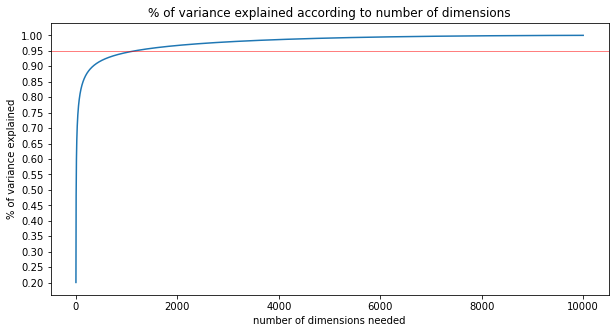

In [123]:
plt.figure(figsize = [10,5])
plt.plot(cumsum)
plt.ylabel("% of variance explained")
plt.xlabel("number of dimensions needed")
xticks = np.arange(0.2,1.01,0.05)
plt.yticks(xticks)
plt.axhline(y=0.95, linewidth=0.5, color='r');
plt.title("% of variance explained according to number of dimensions");

As we can see, even though we have 10000 dimensions, we only need around a 1000 to explain 95% of the variance

In [124]:
pca = PCA(n_components = 0.95)
data_reduced = pca.fit_transform(data_train)
test_reduced = pca.transform(data_test)

In [125]:
data_reduced.shape

(22500, 1166)

In [131]:
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
from sklearn.model_selection import GridSearchCV


In [ ]:
n_range = np.arange(1000,22001,1000)
scores = []
for n in n_range:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(data_reduced,target_train)
    pred = knn.predict(test_reduced)
    scores.append(metrics.accuracy_score(target_test,pred))

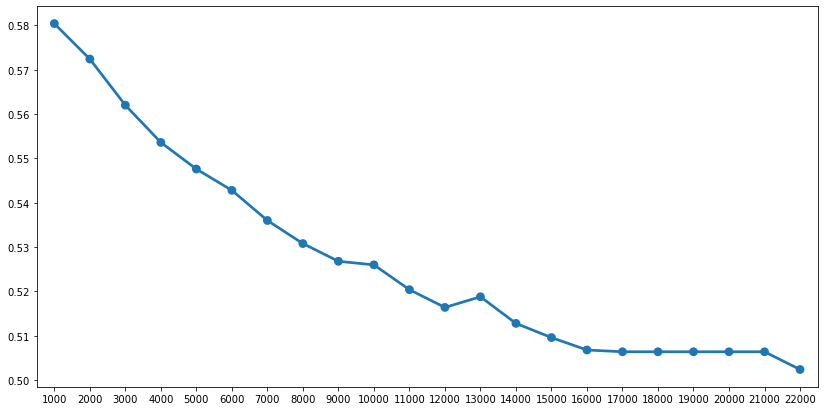

In [129]:
plt.figure(figsize = [14,7])
sns.pointplot(x = n_range, y = scores);

as we can see we dont get a good accuracy with knn lets try Random forest with grid search

In [132]:
RFC = RandomForestClassifier()
param_grid = [{"n_estimators":[100,150,200],"max_depth":[1,2,3] }]
grid_search = GridSearchCV(RFC,param_grid,cv = 5,scoring = "accuracy",return_train_score = True)
grid_search.fit(data_reduced,target_train);

In [133]:
pred = grid_search.predict(test_reduced)
print(metrics.accuracy_score(target_test,pred))

0.5824
